In [236]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from PIL import Image

In [237]:
# Device configuration
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() # For macOS
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [238]:
# Load VGG16 Model
model = models.vgg16(weights='DEFAULT')
 # Remove the last fully connected layer
model = nn.Sequential(*list(model.features.children()))
model = model.to(device)
model.eval()

# Summarize
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [239]:
# Extract features from images
features = {}
directory = 'Images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    feature = model(image)
    feature = feature.view(feature.size(0), -1).detach().cpu().numpy()[0]
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [240]:
# Store features in pickle
with open(os.path.join('./', 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [241]:
# Load features from pickle
with open(os.path.join('./', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [242]:
print(features['3250076419_eb3de15063'])
print(features['3747543364_bf5b548527'])

print(features['3250076419_eb3de15063'].shape)
print(len(features))

[0.66494083 2.135181   0.9853073  ... 7.3553123  5.759862   4.8131127 ]
[0.4479589 0.        0.        ... 0.        0.        0.       ]
(25088,)
8091


In [243]:
# Load captions from the text file
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [244]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [245]:
# Clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [246]:
# Before preprocess of text
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [247]:
# Preprocess the text
clean(mapping)

# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [248]:
all_captions = [caption for captions in mapping.values() for caption in captions]
len(all_captions)

40455

In [249]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [250]:
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Tokenize the text
tokenized_text = [tokenizer(caption) for caption in all_captions]

# Build vocabulary : Mapping every token to an integer index
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_text)
vocab_size = len(vocab)
print(vocab_size)

8896


In [251]:
print(vocab['you'])

1377


In [252]:
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

35


In [253]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.75)
train = image_ids[:split]
test = image_ids[split:]

In [254]:
def one_hot(a, num_classes):
    
    out = np.zeros(num_classes)
    out[a] = 1
    return out
    

In [255]:
class CaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length):
        self.data_keys = data_keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        key = self.data_keys[idx]
        captions = self.mapping[key]

        caption = captions[np.random.choice(len(captions))]
        input1, input2, y = torch.zeros((1, 25088)), torch.zeros(max_length).int(), torch.zeros((max_length, 8896))
        input1[0] = torch.as_tensor(features[key])
        tokens = self.tokenizer(caption)
        caption_indices = [vocab[token] for token in tokens]

        for i in range(1, len(caption_indices)):
            in_seq, out_seq = caption_indices[i-1], caption_indices[i]

            out_seq = int(out_seq)
            out_seq = one_hot(out_seq, num_classes=vocab_size)
         
            input2[i-1] = int(in_seq)

            y[i-1] = torch.as_tensor(out_seq)

        return input1, input2, y


In [256]:
batch_size = 32
train_dataset = CaptionDataset(train, mapping, features, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [257]:
print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1].size())
print(train_dataset.__getitem__(0)[2].size())
# emb = nn.Embedding(vocab_size,5, padding_idx=8896)
# print(emb(train_dataset.__getitem__(0)[1]))

torch.Size([1, 25088])
torch.Size([35])
torch.Size([35, 8896])


In [258]:
class Encoder(nn.Module) :
    def __init__(self, feature_size, hidden_size) :
        super(Encoder, self).__init__()
        self.image_feature_layer = nn.Sequential(
            #nn.Dropout(0.4),
            nn.Linear(feature_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, hidden_size),   
            nn.ReLU(),
        )

    def forward(self, image_input) :
        return self.image_feature_layer(image_input) 


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, sequence_input, h, c):
        se = self.emb(sequence_input)
        
        output, (h, c) = self.lstm(se, (h, c))

        output = self.decoder(output)

        return output, h, c
    

class ImageCaptioningModel(nn.Module) :
    def __init__(self, feature_size, vocab_size, embedding_size, hidden_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(feature_size, hidden_size)
        self.decoder = Decoder(vocab_size, embedding_size, hidden_size)

    def forward(self, image_input, sequence_input, h=None, c=None) :
        fe = self.encoder(image_input)
        c = None
        if h is None :
            if len(fe.size()) == 3 :
                fe = fe.permute(1, 0, 2)
                c = torch.randn(1, fe.shape[1], 256).to(device)
            else : 
                c = torch.randn(1, 256).to(device) 
            return self.decoder(sequence_input, fe, c)
        
        c = torch.randn(1, 256).to(device) 
        return self.decoder(sequence_input, h, c)
            

In [259]:
# Instantiate the model
embedding_size = 256
hidden_size = 256
feature_size = 25088

model = ImageCaptioningModel(feature_size, vocab_size, embedding_size, hidden_size)
model = model.to(device)

In [260]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [261]:
# Train the model
num_epochs = 50
                                                               
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for batch in train_loader:
        inputs1, inputs2, targets = batch

        inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
        hidden, c = None, None
        output, hidden, c = model(inputs1, inputs2, hidden, c)

        # Calculate the loss
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # break
    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/50], Loss: 584.4562
Epoch [2/50], Loss: 318.4875
Epoch [3/50], Loss: 247.7665
Epoch [4/50], Loss: 209.7040
Epoch [5/50], Loss: 183.0347
Epoch [6/50], Loss: 162.8514
Epoch [7/50], Loss: 144.3272
Epoch [8/50], Loss: 132.4423
Epoch [9/50], Loss: 119.7759
Epoch [10/50], Loss: 111.1555
Epoch [11/50], Loss: 106.2748
Epoch [12/50], Loss: 99.4532
Epoch [13/50], Loss: 89.3608
Epoch [14/50], Loss: 83.6927
Epoch [15/50], Loss: 80.3417
Epoch [16/50], Loss: 75.6096
Epoch [17/50], Loss: 68.9420
Epoch [18/50], Loss: 67.7964
Epoch [19/50], Loss: 66.1097
Epoch [20/50], Loss: 59.7051
Epoch [21/50], Loss: 58.5608
Epoch [22/50], Loss: 57.1717
Epoch [23/50], Loss: 56.3582
Epoch [24/50], Loss: 53.4683
Epoch [25/50], Loss: 53.2653
Epoch [26/50], Loss: 51.3482
Epoch [27/50], Loss: 50.6970
Epoch [28/50], Loss: 49.1279
Epoch [29/50], Loss: 48.2279
Epoch [30/50], Loss: 45.7530
Epoch [31/50], Loss: 42.6709
Epoch [32/50], Loss: 45.7337
Epoch [33/50], Loss: 44.6904
Epoch [34/50], Loss: 44.0074
Epoch [35/50

In [262]:
# # Save the model
# torch.save(model.state_dict(), os.path.join('./', 'best_model.pth'))

In [263]:
# Evaluation
def idx_to_word(index):
    try:
        return vocab.get_itos()[index]
    except:
        return None

def predict_caption(model, feature, max_length):
    model.eval()
    input1 = torch.zeros((1, 25088)).to(device)
    input1[0] = torch.as_tensor(feature)
    hidden = None
    c = None 
    input2 = torch.zeros(1).int()
    in_text = 'startseq'
    for _ in range(max_length):
        input2[0] = torch.as_tensor(vocab[in_text.split(' ')[-1]], dtype=torch.int64)
        input2 = input2.to(device)

        outputs, hidden, c = model(input1, input2, hidden, c)

        outputs = F.softmax(outputs, dim=1)
        
        y_pred = torch.argmax(outputs, dim=1).squeeze(0).item()
        
        word = idx_to_word(y_pred)
        in_text += ' ' + word
        
        if word is None or word == 'endseq' :
            break

    return in_text



In [264]:
# BLEU Score Calculation
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print(f"BLEU-1: {bleu1}")
print(f"BLEU-2: {bleu2}")


  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.22584130542817965
BLEU-2: 0.012670381974046059


In [265]:
# Generate caption for an image
def generate_caption(image_name) :
    image_id = image_name.split('.')[0]
    img_path = os.path.join('./', "Images", image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq necklace flies pose gate waits fountain gate endseq
None


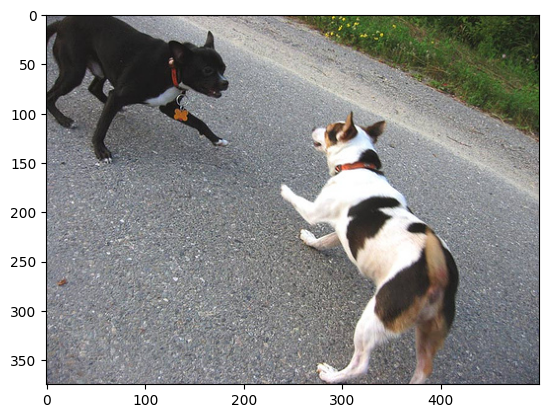

In [266]:
print(generate_caption("1001773457_577c3a7d70.jpg"))

---------------------Actual---------------------
startseq climber stops to take drink while climbing snow covered mountain endseq
startseq man holding cup on snow mountain endseq
startseq man in yellow suit is holding up cup while standing in snow endseq
startseq mountain climber stops for drink endseq
startseq mountaineer in yellow jacket is drinking from thermos cup endseq
--------------------Predicted--------------------
startseq necklace jump endseq
None


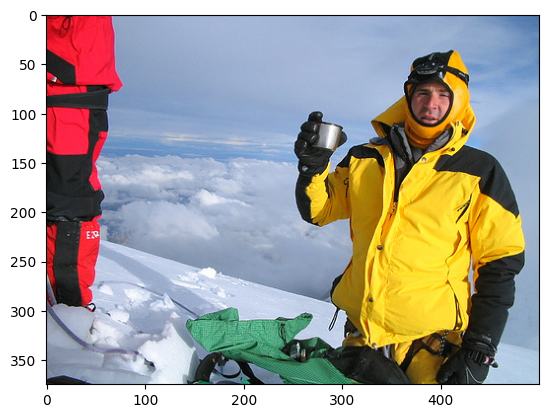

In [267]:
print(generate_caption("55470226_52ff517151.jpg"))

---------------------Actual---------------------
startseq cart containig two men being pulled by horses in the rain endseq
startseq horse driven carriage running through rainstorm endseq
startseq black and white horses carry cart with people through the rain endseq
startseq people enjoy horse draw open carriage in the rain endseq
startseq "the horses pull the carriage holding people and dog through the rain ." endseq
--------------------Predicted--------------------
startseq screen poses door move body terrain stick that vehicles gate jump bars snowy endseq
None


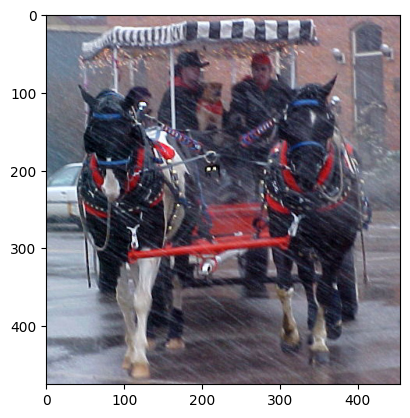

In [268]:
print(generate_caption("97731718_eb7ba71fd3.jpg"))